In [1]:
import pyspark
from pyspark.sql import SparkSession

In [ ]:
# Create a SparkSession
# spark = SparkSession.builder.appName("TestApp").getOrCreate()
# spark = pyspark.sql.SparkSession.builder.appName("MyApp") \
#             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.9") \
#             .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
#             .config("spark.driver.memory", "4g") \
#             .config("spark.executor.memory", "4g") \
#             .getOrCreate()
            
spark = pyspark.sql.SparkSession.builder.appName("MyApp") \
            .config("spark.driver.memory", "4g") \
            .config("spark.executor.memory", "4g") \
            .getOrCreate()

# Check Spark Session Information
spark

25/03/17 15:32:04 WARN Utils: Your hostname, Boths-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.36 instead (on interface en0)
25/03/17 15:32:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/17 15:32:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

In [4]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



### **Data Quality Check**

In [5]:
from pyspark.sql.functions import col, sum

In [6]:
def check_missing_values(df):
    missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
    return missing_values

# Use the function to check for missing values in the DataFrame
missing_values = check_missing_values(df)
missing_values.show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [7]:
# Count total rows and distinct rows
total_rows = df.count()
distinct_rows = df.distinct().count()

print(f"Total Rows: {total_rows}, Distinct Rows: {distinct_rows}")
print(f"Duplicate Rows: {total_rows - distinct_rows}")

Total Rows: 7043, Distinct Rows: 7043
Duplicate Rows: 0


### **Exploratory data analysis**

In [8]:
from pyspark.sql import functions as F
from operator import add
from functools import reduce
from pyspark.sql.functions import sum, count, col, when, size, array, expr
from pyspark.ml.feature import StringIndexer
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Suppress warndings
import warnings

warnings.filterwarnings('ignore')

In [9]:
df.groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



In [10]:
# Calculate churn rate
churn_rate  = df.groupBy().agg((F.sum(when(col("Churn") == "Yes", 1).otherwise(0)) *100/ count("*")).alias("Churn Rate"))
churn_rate.show()

+------------------+
|        Churn Rate|
+------------------+
|26.536987079369588|
+------------------+



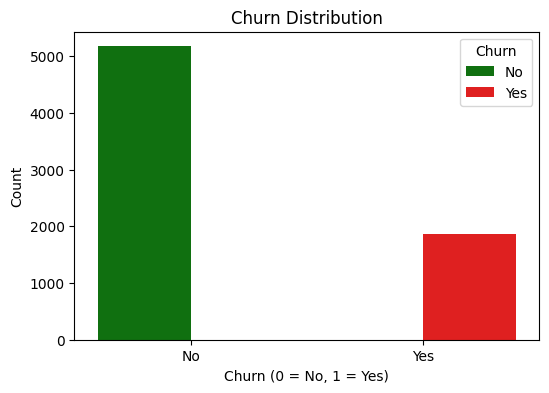

In [11]:
# Convert Churn column to Pandas
churn_data = df.select("Churn").toPandas()

# # Convert Yes to 1 and No to 0
# churn_data["Churn"] = churn_data["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

# Set color palette for 0 (green) and 1 (red)
plt.figure(figsize=(6,4))
sns.countplot(data=churn_data, x="Churn", hue ="Churn", palette={"No": 'green', "Yes": 'red'})
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

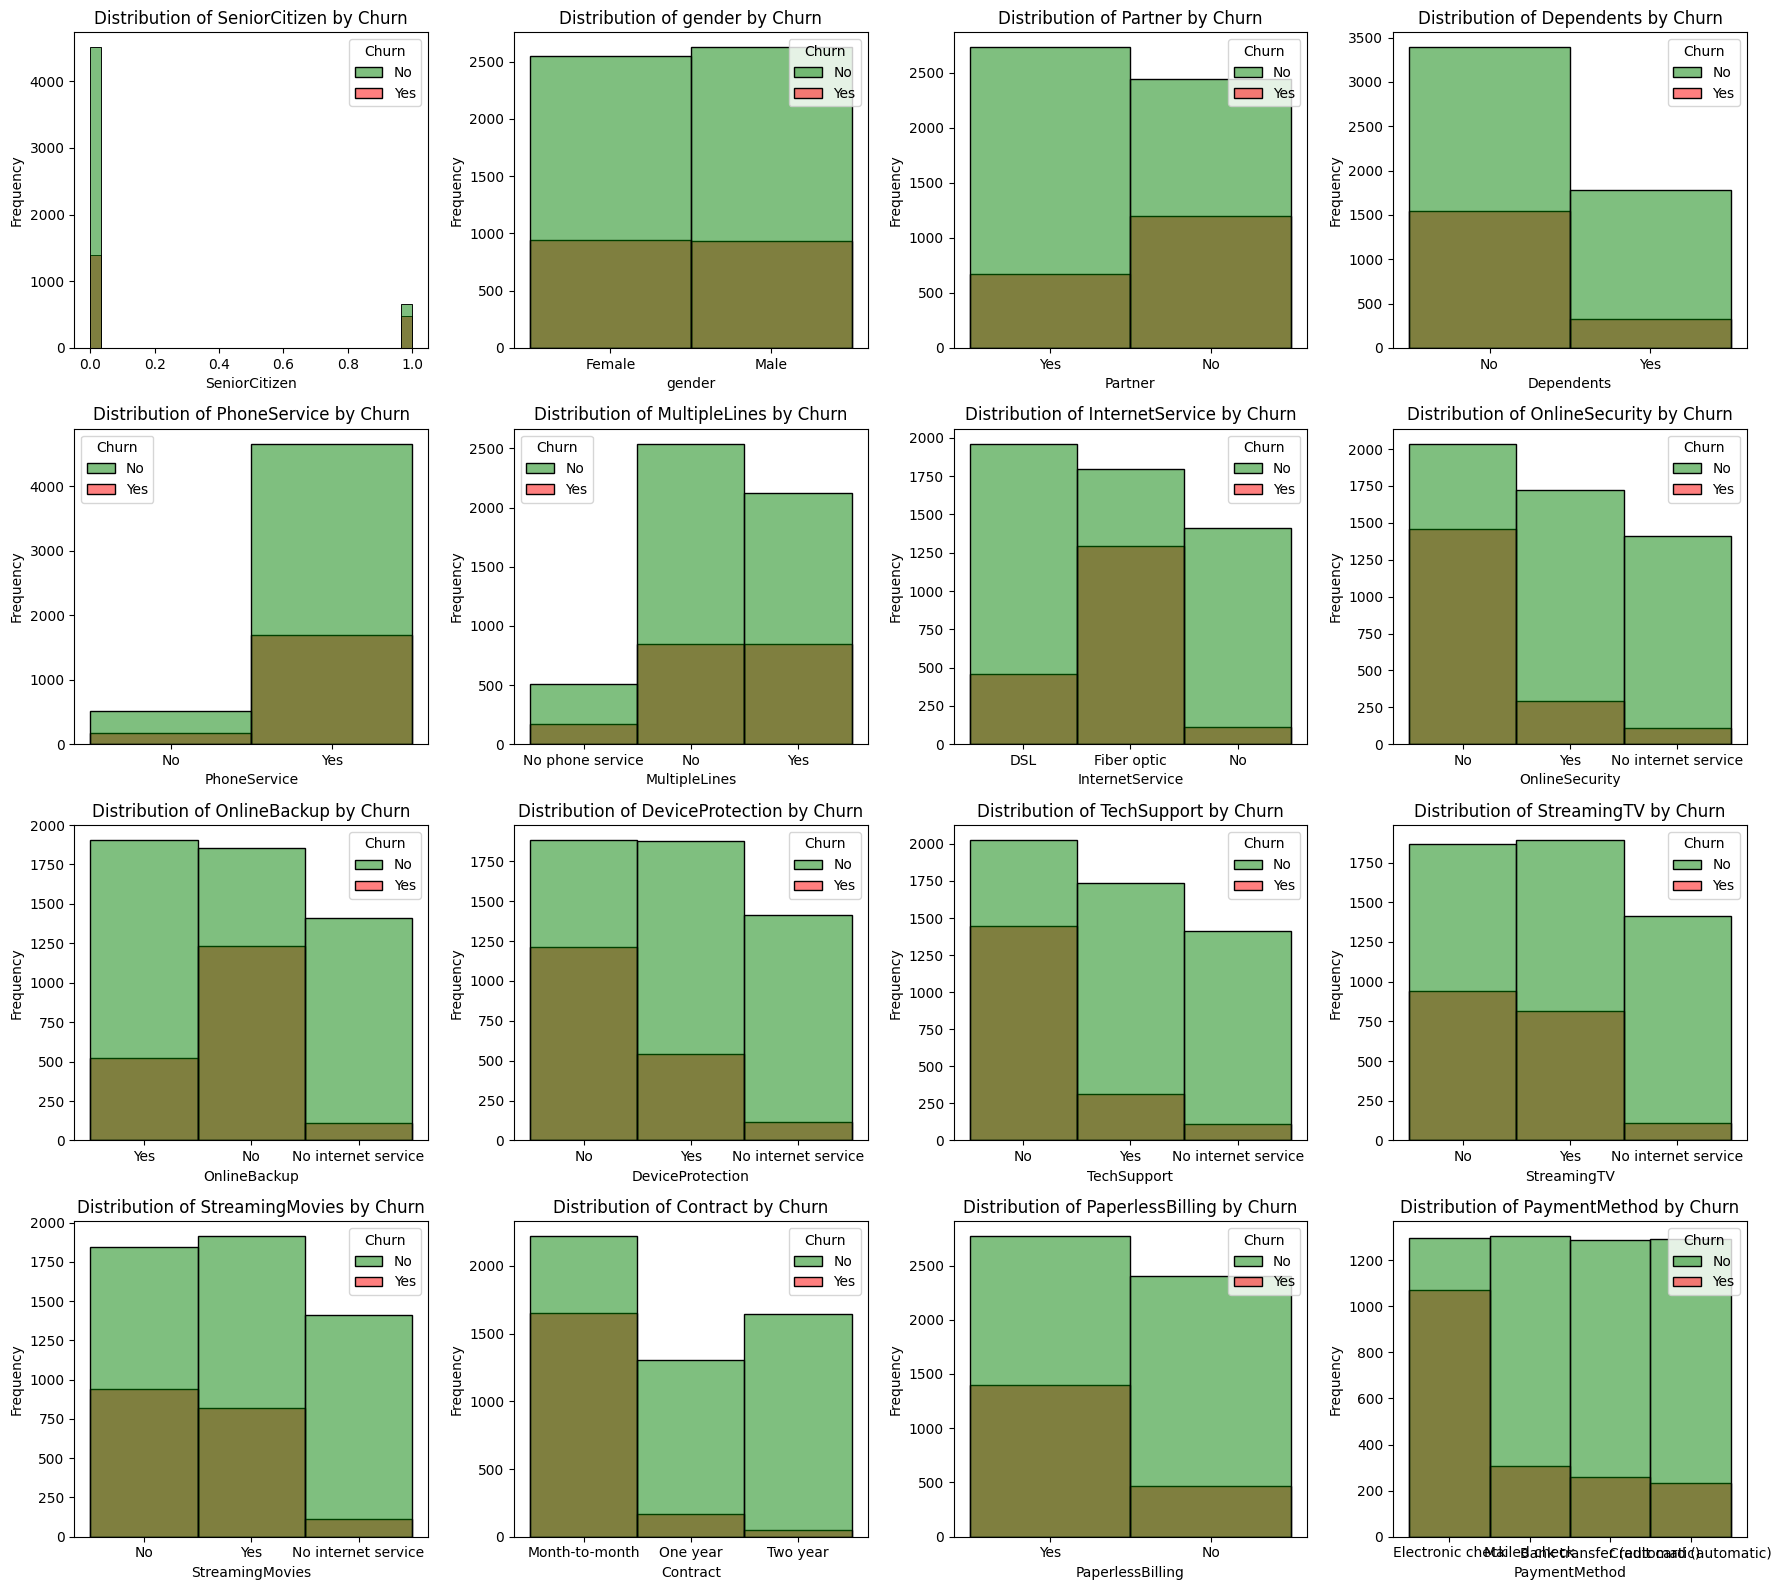

In [12]:
cat_name = ['SeniorCitizen','gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

# Calculate the number of rows and columns for the subplots grid
n_cols = 4
n_rows = (len(cat_name) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))

for i, col_name in enumerate(cat_name):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    num_data = df.select(col_name, "Churn").toPandas()

    sns.histplot(data=num_data, x=col_name, hue="Churn", kde=False, bins=30, palette={"No": 'green', "Yes": 'red'}, ax=ax)
    ax.set_title(f"Distribution of {col_name} by Churn")
    ax.set_xlabel(col_name)
    ax.set_ylabel("Frequency")

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

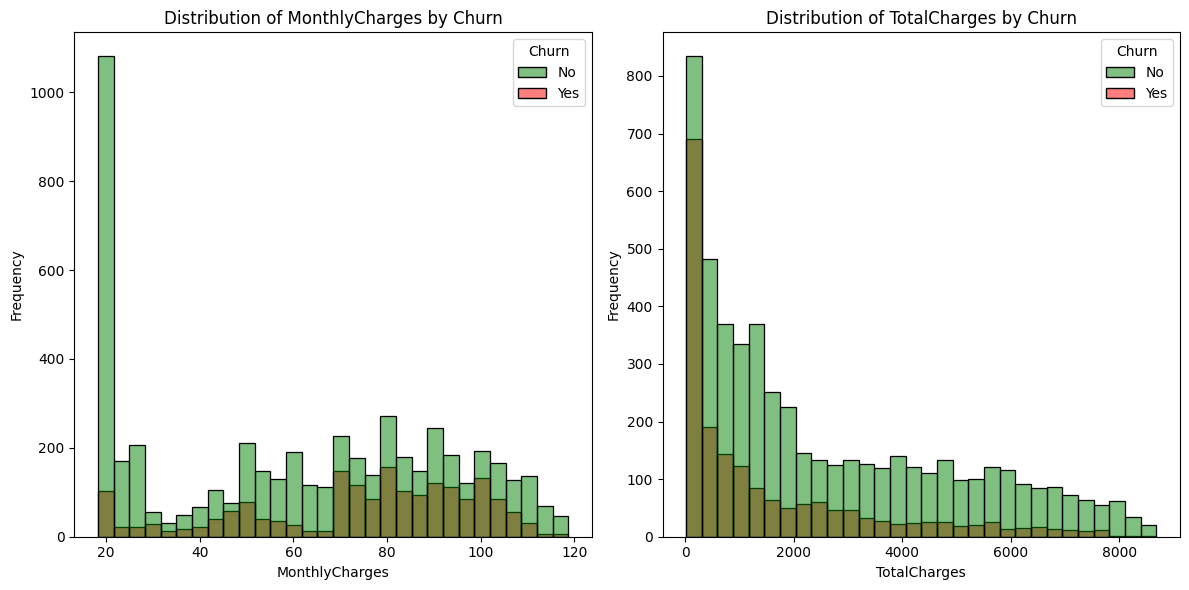

In [13]:
# Convert TotalCharges to float
df = df.withColumn("TotalCharges", df["TotalCharges"].cast("double"))

# Convert to Pandas DataFrame
num_data = df.select("MonthlyCharges", "TotalCharges", "Churn").toPandas()

# Plot MonthlyCharges
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=num_data, x="MonthlyCharges", hue="Churn", kde=False, bins=30, palette={"No": 'green', "Yes": 'red'})
plt.title("Distribution of MonthlyCharges by Churn")
plt.xlabel("MonthlyCharges")
plt.ylabel("Frequency")

# Plot TotalCharges
plt.subplot(1, 2, 2)
sns.histplot(data=num_data, x="TotalCharges", hue="Churn", kde=False, bins=30, palette={"No": 'green', "Yes": 'red'})
plt.title("Distribution of TotalCharges by Churn")
plt.xlabel("TotalCharges")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [14]:
# Convert categorical columns to numerical values
cat_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
               'PaperlessBilling', 'PaymentMethod', 'Churn']

indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index") for col_name in cat_columns]


df_encoded = df
for indexer in indexers:
    df_encoded = indexer.fit(df_encoded).transform(df_encoded)

In [15]:
# Drop original categorical columns and keep the new indexed ones
df_eda = df_encoded.drop(*cat_columns)
df_eda = df_eda.drop("customerID")
df_eda.show(5)

+-------------+------+--------------+------------+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+-----------+
|SeniorCitizen|tenure|MonthlyCharges|TotalCharges|gender_index|Partner_index|Dependents_index|PhoneService_index|MultipleLines_index|InternetService_index|OnlineSecurity_index|OnlineBackup_index|DeviceProtection_index|TechSupport_index|StreamingTV_index|StreamingMovies_index|Contract_index|PaperlessBilling_index|PaymentMethod_index|Churn_index|
+-------------+------+--------------+------------+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+---------------

In [16]:
df_eda = df_eda.withColumnRenamed("Churn_index", "Churn")

# Convert to Pandas DataFrame
df_eda_pd = df_eda.toPandas()

# Compute correlation matrix
correlation_matrix = df_eda_pd.corr()

# Display correlation with Churn
print(correlation_matrix["Churn"].sort_values(ascending=False))

Churn                     1.000000
MonthlyCharges            0.193356
SeniorCitizen             0.150889
MultipleLines_index       0.019423
gender_index              0.008612
PhoneService_index       -0.011942
Partner_index            -0.150448
Dependents_index         -0.164221
PaperlessBilling_index   -0.191825
TotalCharges             -0.199484
StreamingTV_index        -0.205742
StreamingMovies_index    -0.207256
PaymentMethod_index      -0.262818
DeviceProtection_index   -0.281465
OnlineBackup_index       -0.291449
InternetService_index    -0.316846
TechSupport_index        -0.329852
OnlineSecurity_index     -0.332819
Contract_index           -0.341504
tenure                   -0.352229
Name: Churn, dtype: float64


In [17]:
corr_matrix  = correlation_matrix["Churn"].sort_values(ascending=False)
print('Most Positive Correlations:\n', corr_matrix.head(3))
print('\nMost Negative Correlations:\n', corr_matrix.tail(3))

Most Positive Correlations:
 Churn             1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
Name: Churn, dtype: float64

Most Negative Correlations:
 OnlineSecurity_index   -0.332819
Contract_index         -0.341504
tenure                 -0.352229
Name: Churn, dtype: float64


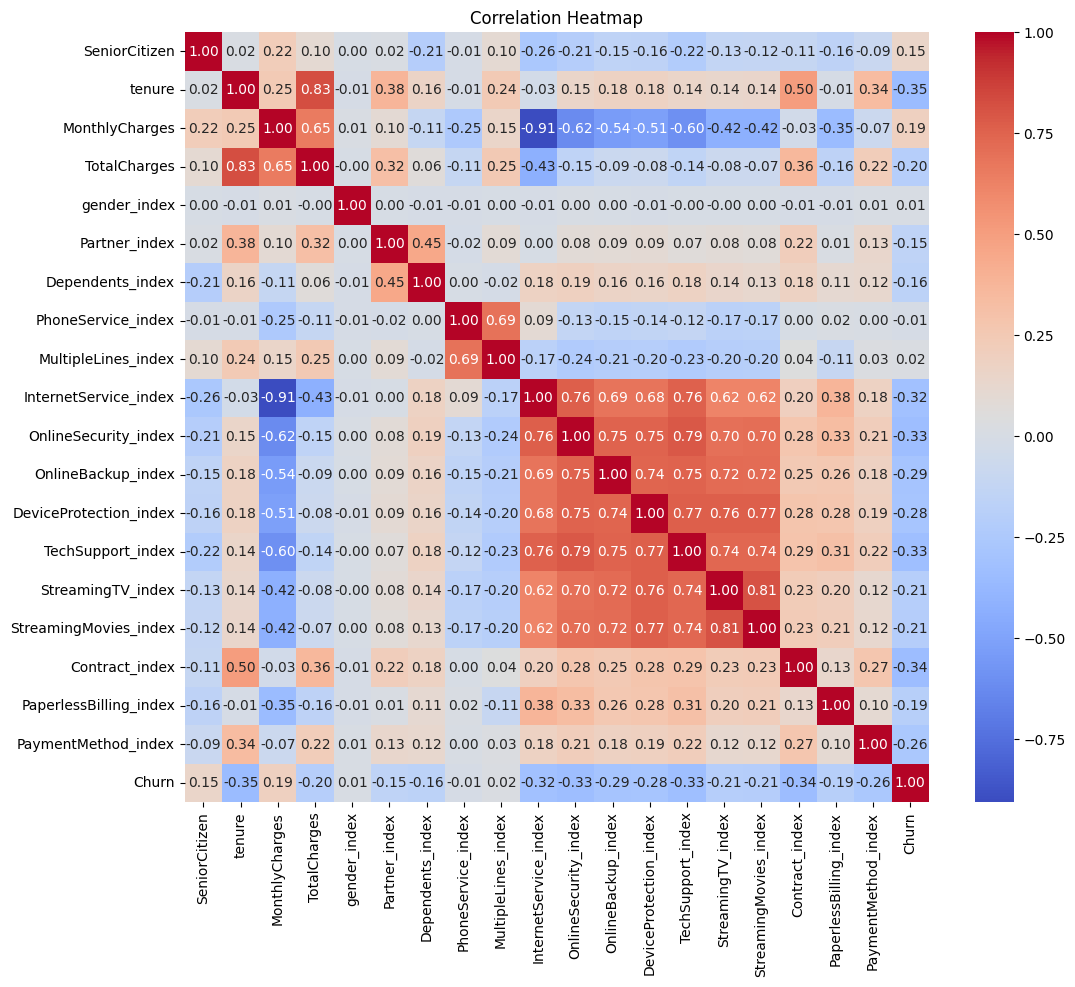

In [18]:
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

### **Model Building**

In [19]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from sklearn.metrics import roc_auc_score,confusion_matrix,precision_recall_curve,auc
import math

In [20]:
# Load data
df_final = df # Use the Dataframe prior encoder for EDA
target_col = "Churn"  # Replace with your actual target column

In [21]:
# Drop CustomerID
df_final = df_final.drop("customerID")

# Cast SeniorCitizen to String
df_final = df_final.withColumn("SeniorCitizen", col("SeniorCitizen").cast("string"))

In [22]:
# Convert Churn column from string to integer
df_final = df_final.withColumn("Churn", when(col("Churn") == "Yes", 1).otherwise(0))

In [23]:
# Define train-test ratio
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Split each class separately
minority_class = df_final.filter(F.col(target_col) == 1)
majority_class = df_final.filter(F.col(target_col) == 0)

train_minority, test_minority = minority_class.randomSplit([train_ratio, test_ratio], seed=42)
train_majority, test_majority = majority_class.randomSplit([train_ratio, test_ratio], seed=42)

# Combine training and testing sets
train_data = train_minority.union(train_majority)
test_data = test_minority.union(test_majority)

# Verify class balance in the new splits
train_data.groupBy(target_col).count().orderBy("count", ascending=False).show()
test_data.groupBy(target_col).count().orderBy("count", ascending=False).show()

+-----+-----+
|Churn|count|
+-----+-----+
|    0| 4173|
|    1| 1541|
+-----+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|    0| 1001|
|    1|  328|
+-----+-----+



In [24]:
# Oversample the minority class
minority_df = train_data.filter(col(target_col) == 1)
majority_df = train_data.filter(col(target_col) == 0)

# Perform oversampling on the minority class (increase the fraction as needed)
oversampled_minority_df = minority_df.sample(withReplacement=True, fraction=4.0, seed=42)
balanced_df = majority_df.union(oversampled_minority_df)

In [25]:
# Verify class balance in the new splits
balanced_df.groupBy(target_col).count().orderBy("count", ascending=False).show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 6265|
|    0| 4173|
+-----+-----+



In [26]:
# Identify categorical and numerical columns
categorical_cols = [col_name for col_name, dtype in balanced_df.dtypes if dtype == 'string']

# Apply StringIndexer to each categorical column
indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index") for col_name in categorical_cols]

In [27]:
# Compute class distribution for scale_pos_weight
class_counts = balanced_df.groupBy(target_col).count().collect()

# Compute scale_pos_weight
negative_count = class_counts[0]['count']
positive_count = class_counts[1]['count']
scale_pos_weight = math.sqrt(negative_count / positive_count) # scaling weight for XGBoost

In [28]:
# Identify categorical and numerical columns
categorical_cols = [col_name for col_name, dtype in balanced_df.dtypes if dtype == 'string']
numerical_cols = [col_name for col_name, dtype in balanced_df.dtypes if dtype in ('int', 'double','float')]
print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

Categorical Columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Columns: ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [29]:
# Apply StringIndexer to each categorical column
indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index") for col_name in categorical_cols]

# Define feature columns (excluding original categorical columns)
feature_cols = [col for col in balanced_df.columns if col not in ["customerID", target_col] and col not in categorical_cols]
feature_cols += [f"{col}_index" for col in categorical_cols]  # Add encoded categorical features

In [30]:
# Vector Assembler (Only include numeric + indexed categorical features)
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")

In [31]:
# Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol=target_col)

# Random Forest Model
rf = RandomForestClassifier(featuresCol="features", labelCol=target_col, numTrees=100)


In [32]:
# Create Pipelines (Dropping categorical columns after encoding)
pipeline_lr = Pipeline(stages=indexers + [vector_assembler, lr])
pipeline_rf = Pipeline(stages=indexers + [vector_assembler, rf])

In [33]:
# Create pipeline to preprocess training data for LightGBM
pipeline_xgb = Pipeline(stages=indexers)
pipeline_lgb = Pipeline(stages=indexers)

In [34]:
# Train Models
model_lr = pipeline_lr.fit(balanced_df)
model_rf = pipeline_rf.fit(balanced_df)

25/03/17 15:33:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [35]:
# Transform Train data to check overfitting
predictions_lr_train = model_lr.transform(train_data)
predictions_rf_train = model_rf.transform(train_data)

In [36]:
# Transform test data
predictions_lr = model_lr.transform(test_data)
predictions_rf = model_rf.transform(test_data)

In [37]:
# Evaluate Logistic Regression
evaluator = BinaryClassificationEvaluator(labelCol=target_col, rawPredictionCol="probability", metricName="areaUnderROC")

In [38]:
lr_auc_train = evaluator.evaluate(predictions_lr_train)
print(f"Logistic Regression AUC-Train: {lr_auc_train:.4f}")
lr_auc_test = evaluator.evaluate(predictions_lr)
print(f"Logistic Regression AUC-Test: {lr_auc_test:.4f}")

Logistic Regression AUC-Train: 0.8493
Logistic Regression AUC-Test: 0.8375


In [39]:
rf_auc_train = evaluator.evaluate(predictions_rf_train)
print(f"Random Forest AUC-Train: {rf_auc_train:.4f}")
rf_auc_test = evaluator.evaluate(predictions_rf)
print(f"Random Forest AUC-Test: {rf_auc_test:.4f}")

Random Forest AUC-Train: 0.8545
Random Forest AUC-Test: 0.8305


In [40]:
# Fit pipeline to XGBoost
pipeline_xg_model = pipeline_xgb.fit(balanced_df)

# Transform balance data for training models
train_bal_data_xgb = pipeline_xg_model.transform(balanced_df)

# Transform Train and test data
train_data_xgb = pipeline_xg_model.transform(train_data)
test_data_xgb = pipeline_xg_model.transform(test_data)

# Copy Train and Test dataset to Pandas for LightGBM
train_bal_xg_final = train_bal_data_xgb.toPandas()
train_df_xg_final = train_data_xgb.toPandas()
test_df_xg_final = test_data_xgb.toPandas()


# Drop Categorical
# Identify categorical and numerical columns
categorical_cols = [col_name for col_name, dtype in train_bal_data_xgb.dtypes if dtype == 'string']
train_bal_xg_final = train_bal_xg_final.drop(columns=categorical_cols)  # Categorical columns
train_df_xg_final = train_df_xg_final.drop(columns=categorical_cols)  # Categorical columns
test_df_xg_final = test_df_xg_final.drop(columns=categorical_cols)  # Categorical columns

# Define features and label
X_train_bal = train_bal_xg_final.drop(columns=["Churn"])  # Drop ID & label
y_train_bal = train_bal_xg_final["Churn"]

X_train = train_df_xg_final.drop(columns=["Churn"])
y_train = train_df_xg_final["Churn"]

X_test = test_df_xg_final.drop(columns=[ "Churn"])
y_test = test_df_xg_final["Churn"]


25/03/17 15:33:41 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [41]:
# Initialize XGBoost classifier with class imbalance handling
xg_classifier = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss') 


In [42]:
xg_classifier.fit(X_train_bal, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [43]:
# Predict probabilities
y_pred_proba_train =  xg_classifier.predict_proba(X_train)[:, 1]
y_pred_proba = xg_classifier.predict_proba(X_test)[:, 1]

In [44]:
# Compute AUC Train Score
auc_score = roc_auc_score(y_train, y_pred_proba_train)
print(f"AUC Train Score: {auc_score:.4f}")

# Compute AUC Test Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Test Score: {auc_score:.4f}")

AUC Train Score: 0.9839
AUC Test Score: 0.8213


In [45]:
# Fit pipeline to XGBoost
pipeline_lgb_model = pipeline_lgb.fit(balanced_df)

# Transform balance data for training models
train_bal_data_lgb = pipeline_lgb_model.transform(balanced_df)

# Transform Train and test data
train_data_lgb = pipeline_lgb_model.transform(train_data)
test_data_lgb = pipeline_lgb_model.transform(test_data)

# Copy Train and Test dataset to Pandas for LightGBM
train_bal_lgb_final = train_bal_data_lgb.toPandas()
train_df_lgb_final = train_data_lgb.toPandas()
test_df_lgb_final = test_data_lgb.toPandas()

# Drop Categorical
# Identify categorical and numerical columns
categorical_cols = [col_name for col_name, dtype in train_bal_data_lgb.dtypes if dtype == 'string']

train_bal_lgb_final  = train_bal_lgb_final.drop(columns=categorical_cols)
train_df_lgb_final = train_df_lgb_final.drop(columns=categorical_cols)
test_df_lgb_final = test_df_lgb_final.drop(columns=categorical_cols)

# Define features and label
X_train_bal = train_bal_lgb_final.drop(columns=["Churn"])  # Drop ID & label
y_train_bal = train_bal_lgb_final["Churn"]

X_train = train_df_lgb_final.drop(columns=["Churn"])
y_train = train_df_lgb_final["Churn"]

X_test = test_df_lgb_final.drop(columns=[ "Churn"])
y_test = test_df_lgb_final["Churn"]


In [46]:
# Initialize LightGBM classifier with class imbalance handling
lgb_classifier = LGBMClassifier(objective='binary', 
                scale_pos_weight=scale_pos_weight,
                # is_unbalance=True,
                random_state=42)

In [47]:
lgb_classifier.fit(X_train_bal, y_train_bal)

LGBMClassifier(objective='binary', random_state=42,
               scale_pos_weight=0.8161381038947334)

In [48]:
# Predict probabilities
y_pred_proba_train =  lgb_classifier.predict_proba(X_train)[:, 1]
y_pred_proba = lgb_classifier.predict_proba(X_test)[:, 1]

In [49]:
# Compute AUC Train Score
auc_score = roc_auc_score(y_train, y_pred_proba_train)
print(f"AUC Train Score: {auc_score:.4f}")

# Compute AUC Test Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Test Score: {auc_score:.4f}")

AUC Train Score: 0.9471
AUC Test Score: 0.8333


In [50]:
from sklearn.model_selection import GridSearchCV

In [71]:
# Define the parameter grid for LightGBM
param_grid = {
    'learning_rate': [0.05,  0.1],
    'max_depth': [5, 7, 10],
    'num_leaves': [15, 31],
    'min_child_samples': [20, 50, 100],  # Minimum number of data points in a leaf
    'subsample': [0.6, 0.8],  # Subsample ratio of the training instance
    'reg_alpha': [0.1, 0.5, 1],  # L1 regularization
    'reg_lambda': [0.1, 0.5, 1]  # L2 regularization
}


In [72]:
# Initialize LightGBM classifier
lgb_classifier = LGBMClassifier(
    objective="binary",
    scale_pos_weight=scale_pos_weight,
    # is_unbalance = True,
    random_state=42
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=lgb_classifier,
    param_grid=param_grid,
    scoring='roc_auc',  # Use AUC as the evaluation metric
    cv=3,  # Use 3-fold cross-validation (adjust as needed)
    verbose=1,
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

# Fit the grid search to the data
grid_search.fit(X_train_bal, y_train_bal)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best AUC score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 100, 'num_leaves': 31, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.6}
Best AUC score: 0.8012


In [73]:
# Get the best model and its hyperparameters
best_lgb_classifier = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

# Evaluate the best model
y_pred_proba_train = best_lgb_classifier.predict_proba(X_train)[:, 1]
auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
print(f"AUC Train Score (Best Model): {auc_score_train:.4f}")

y_pred_proba = best_lgb_classifier.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Test Score (Best Model): {auc_score:.4f}")

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 100, 'num_leaves': 31, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.6}
AUC Train Score (Best Model): 0.8885
AUC Test Score (Best Model): 0.8426


In [74]:
importances = best_lgb_classifier.feature_importances_

  # Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

selected_features = feature_importances['feature']

#### Model Explanability

In [75]:
import shap
import numpy as np

In [76]:
np.float = float  # Temporary fix for deprecated alias if numpy version is greater than 1.20.0

In [77]:
# Compute SHAP values
explainer = shap.TreeExplainer(best_lgb_classifier)
# shap_values = explainer(X_train)
shap_values = explainer.shap_values(X_train)[1]

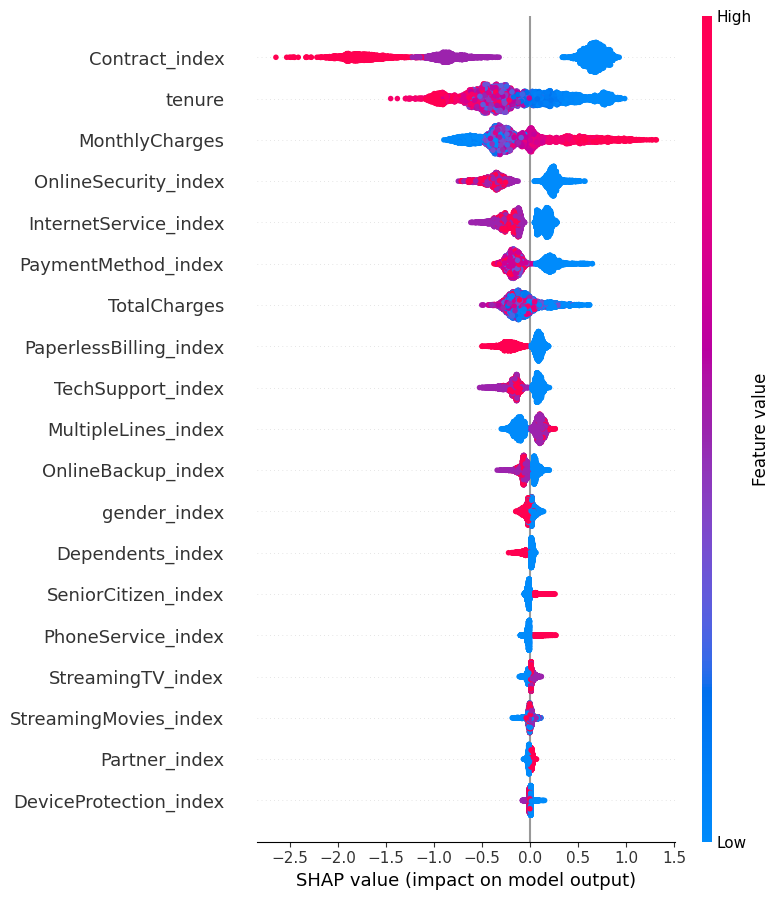

In [78]:
# Summary plot
shap.summary_plot(shap_values, X_train) 

In [79]:
def plot_shap_dependence(shap_values, X_train, selected_features, num_features=5):
    """
    Plots SHAP dependence plots for the top important features.

    Parameters:
    shape_values: SHAP values
    X_train_selected: The training data with selected features
    selected_features (list): List of selected feature names
    num_features (int): Number of top features to plot
    """

    # Convert Explanation object to NumPy array
    shap_values_array = shap_values.values if isinstance(shap_values, shap.Explanation) else shap_values

    # Compute feature importance based on SHAP values
    importance = np.abs(shap_values_array).mean(axis=0)  # Mean absolute SHAP value
    feature_importance = pd.DataFrame({'feature': selected_features, 'importance': importance})

    # Select top features from SHAP importance
    top_features = feature_importance.sort_values(by='importance', ascending=False).head(num_features)['feature']

    # Plot SHAP dependence plots
    for feature in top_features:
        shap.dependence_plot(feature, shap_values_array, X_train[selected_features])

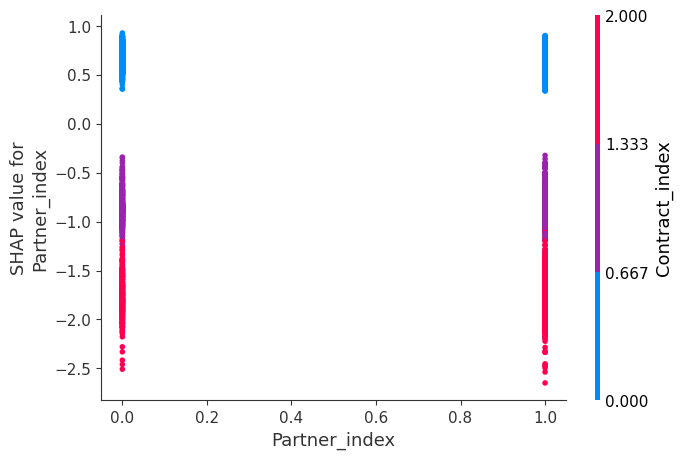

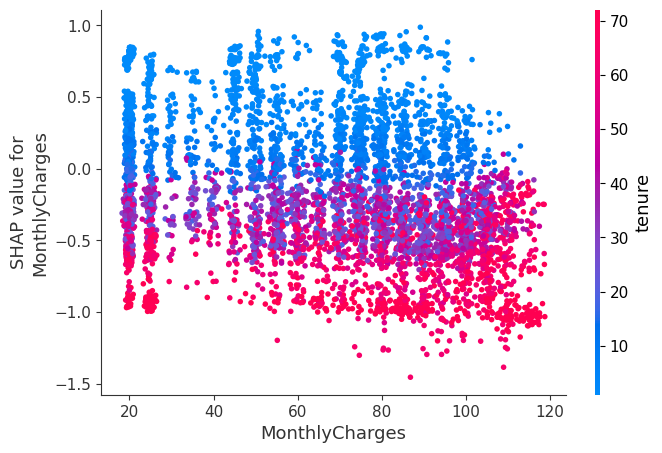

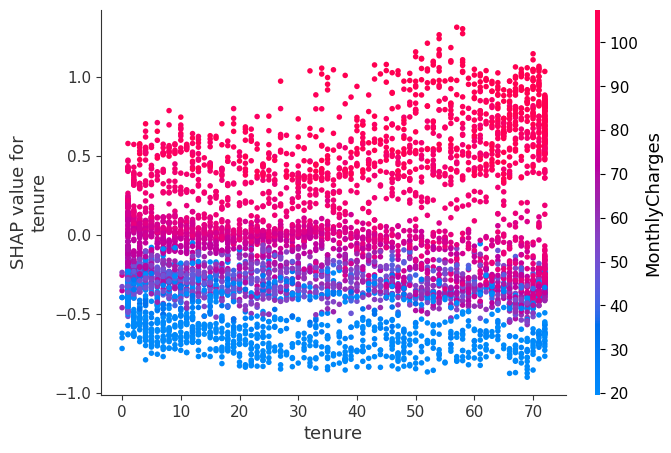

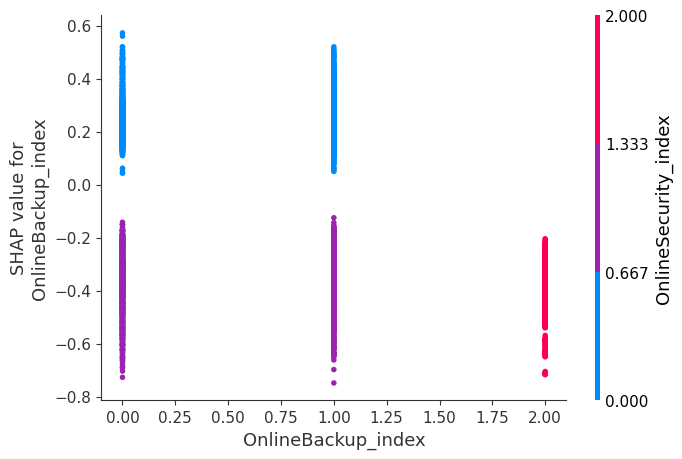

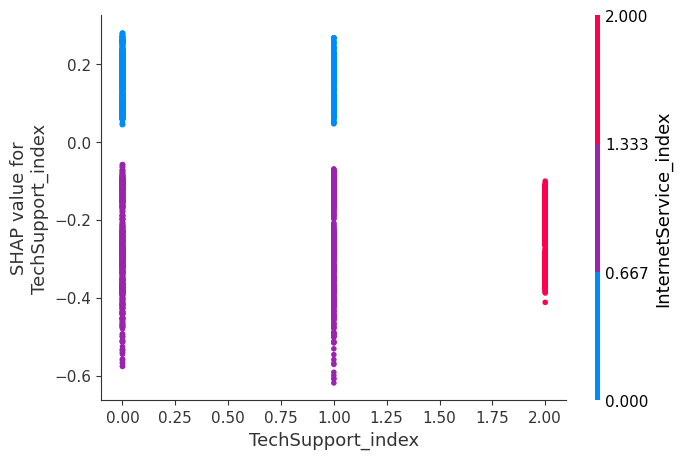

In [80]:
plot_shap_dependence(shap_values, X_train, selected_features, num_features=5)

#### Showcase when the model is reliable and has a proper threshold

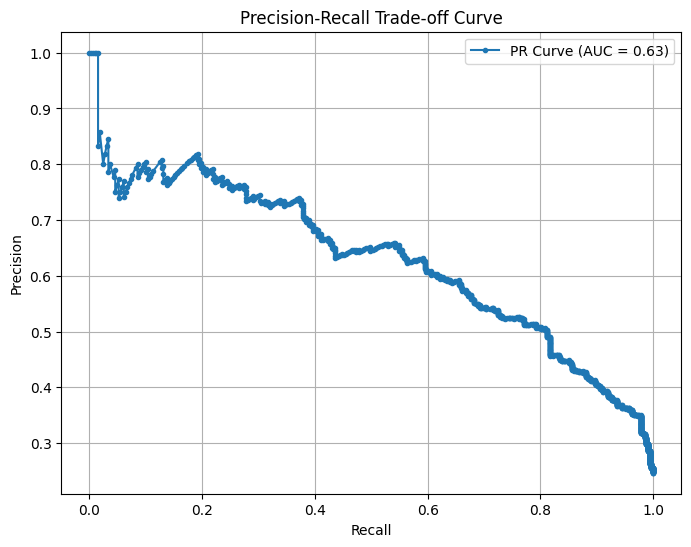

In [81]:
# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Compute AUC-PR (Area under Precision-Recall Curve)
auc_pr = auc(recall, precision)

# Plot Precision-Recall Trade-off Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR Curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Trade-off Curve')
plt.legend()
plt.grid(True)
plt.show()

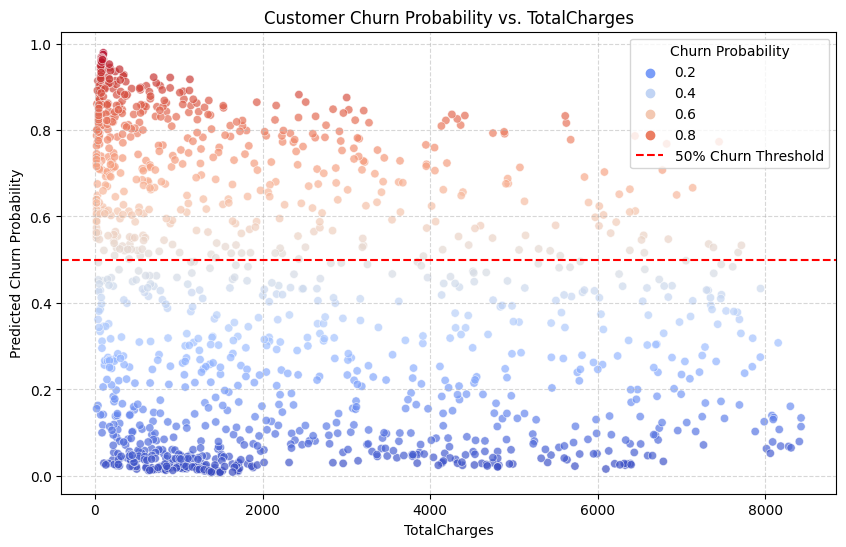

In [82]:
# Convert to Pandas DataFrame for easy plotting
results_df = pd.DataFrame({
    "TotalCharges": X_test["TotalCharges"],  # Ensure 'ARPU' exists in X_test
    "Churn_Probability": y_pred_proba
})

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x="TotalCharges",
    y="Churn_Probability",
    hue="Churn_Probability",  # Color by churn probability
    palette="coolwarm",
    alpha=0.7
)

# Labels & Formatting
plt.xlabel("TotalCharges")
plt.ylabel("Predicted Churn Probability")
plt.title("Customer Churn Probability vs. TotalCharges")
plt.axhline(y=0.5, color="red", linestyle="--", label="50% Churn Threshold")  # Mark threshold
plt.legend(title="Churn Probability")
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

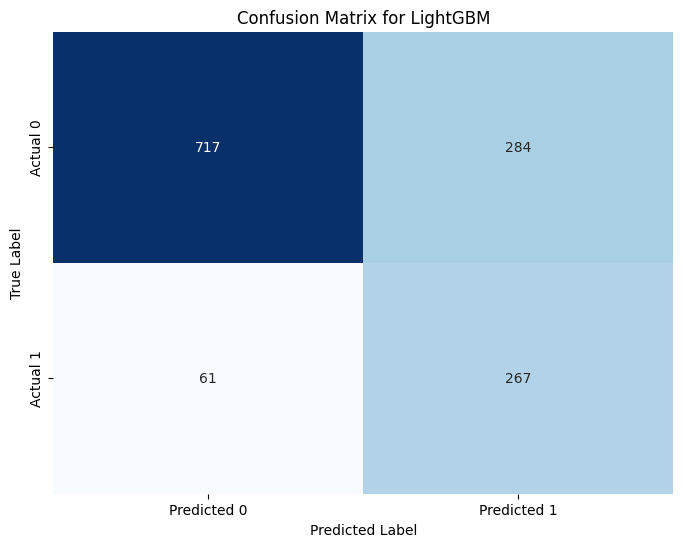

In [70]:
# This example might need to adjust this based on how you obtained these values.
y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix for LightGBM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
spark.stop()